In [38]:
%matplotlib inline
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

inp_path = '../COL780-A1-Data/baseline/input'
out_path = '../COL780-A1-Data/baseline/preds'
category = 'b'
eval_frames = '../COL780-A1-Data/baseline/eval_frames.txt'

args = argparse.Namespace(
    inp_path=inp_path,
    out_path=out_path,
    category=category,
    eval_frames=eval_frames
)

In [39]:
fgbg = cv2.createBackgroundSubtractorMOG2()

In [40]:
def get_input_frames(args, bnw=False):
    '''
    Get list of (image name, image as a numpy array)
    Params
    ------
    bnw : Bool
        convert to black and white
    '''
    filenames = os.listdir(args.inp_path)
    inp_frames = []
    for i, filename in enumerate(filenames):
        img = cv2.imread(os.path.join(args.inp_path, filename))
        if bnw:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        inp_frames.append((filename, img))
    inp_frames = sorted(inp_frames, key=lambda x : x[0])
    return inp_frames

inp_frames = get_input_frames(args, True)

In [41]:
def get_eval_indices(args):
    '''
    Get start and end index as given in eval_frames
    '''
    s, e = 0, 0
    with open(args.eval_frames, 'r') as f:
        s, e = map(int, f.readline().split())
    return s, e

def write_output_frames(args, out_frames):
    '''
    Write output frames to file
    '''
    if not os.path.isdir(args.out_path):
        os.mkdir(args.out_path)

    for filename, img in out_frames:
        filename = 'gt' + filename[2:-3] + 'png'
        cv2.imwrite(os.path.join(args.out_path, filename), img)

In [42]:
def baseline_bgs(args):
    # Ref:
    # https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    # https://en.wikipedia.org/wiki/Foreground_detection
    
#     inp_frames = get_input_frames(args)

    # Get mean at each pixel
    mean = inp_frames[0][1].astype(float)
    num_frames = len(inp_frames)
    for i in range(1, num_frames):
        mean = np.add(mean, inp_frames[i][1])
    mean = mean / num_frames
    mean = mean.astype(int)
    
    s, e = get_eval_indices(args)
    
    k = 40 # threshold
    kernel = np.ones((5,5),np.uint8)
    
    out_frames = []
    # Declare foreground if I - mean >= k
    for i in range(s-1, e):
        filename, img = inp_frames[i]
        mask = (np.abs(img - mean) >= k) * 255
        mask = mask.astype('uint8')
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        out_frames.append((filename, mask))

    write_output_frames(args, out_frames)


def illumination_bgs(args):
    #TODO complete this function
    s, e = get_eval_indices(args)
    for i in range(s):
        fgbg.apply(inp_frames[i][1])
    out_frames = []
    for i in range(s-1,e):
        mask = fgbg.apply(inp_frames[i][1])
        out_frames.append((inp_frames[i][0], mask))
        
    write_output_frames(args, out_frames)


def jitter_bgs(args):
    #TODO complete this function
    pass


def dynamic_bgs(args):
    #TODO complete this function
    pass


def ptz_bgs(args):
    #TODO: (Optional) complete this function
    pass

In [43]:
FUNCTION_MAPPER = {
        "b": baseline_bgs,
        "i": illumination_bgs,
        "j": jitter_bgs,
        "m": dynamic_bgs,
        "p": ptz_bgs
    }

FUNCTION_MAPPER[args.category](args)

In [44]:
def show_image_rgb(img):
    plt.imshow(img[:,:,::-1])
    plt.show()
    
def show_image_gray(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [51]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

(240, 320)
(240, 320)


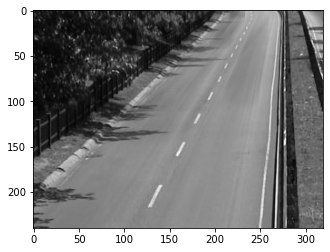

In [52]:
variance_matrix = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

mean = inp_frames[0][1].astype(float)
var = convolve2D(mean,variance_matrix,padding=1)
num_frames = len(inp_frames)

print(var.shape)

"""
for i in range(1, num_frames):
    mean = np.add(mean, inp_frames[i][1])
mean = mean / num_frames
mean = mean.astype(int)
"""

wro = 0.01

for i in range(1, num_frames):
    mean = wro*inp_frames[i][1] + (1-wro)*mean
    d = np.abs(mean - inp_frames[i][1])
    d = d*d
    var = wro*d + (1-wro)*var
    
mean = mean.astype(int)
stddev = np.sqrt(var)

print(mean.shape)
show_image_gray(mean)

in000687.jpg


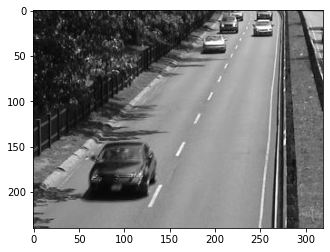

In [53]:
filename, img = inp_frames[686]
print(filename)
show_image_gray(img)

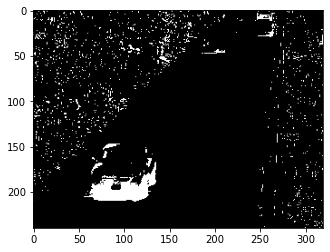

In [60]:
filename, img = inp_frames[686]
mask = ((np.abs((img - mean)/stddev) >= 2.5) * 255).astype('uint8')
show_image_gray(mask)

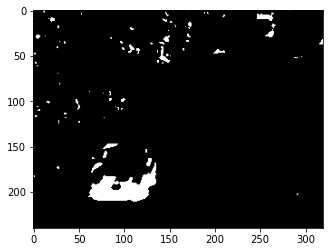

In [61]:
mask = (cv2.GaussianBlur(mask, (5, 5), 0) > 100) * 255
show_image_gray(mask)

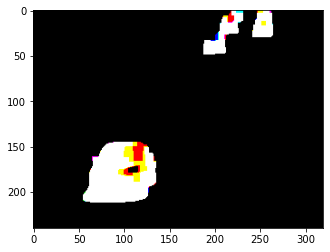

In [ ]:
kernel = np.ones((5,5),np.uint8)
mask = mask.astype('uint8')
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# mask = cv2.dilate(mask,kernel,iterations = 2)
# Enlarge the mask
# dilatation_size = 15
# Options: cv.MORPH_RECT, cv.MORPH_CROSS, cv.MORPH_ELLIPSE
# dilatation_type = cv2.MORPH_CROSS
# element = cv2.getStructuringElement(dilatation_type,(2*dilatation_size + 1, 2*dilatation_size+1),(dilatation_size, dilatation_size))
# mask = cv2.dilate(mask, element)
show_image_gray(mask)